# Introduction

### Case study - enzyme classification

Enzymes are classified by the Nomenclature Committee of the International Union of Biochemistry into Enzyme Comission (EC) numbers, a four digit numerical representation separated by periods (e.g. 2.6.1.9). 

The four levels of EC numbers are related to each other in a functional hierarchy. The first number describes one of the 7 main enzymatic classes, the second describes the subclass, the third represents the sub-subclass and the fourth refers to the substrate of the enzyme.

Here, we will predict the subclass for the class 2 (transferases).


### Dataset

We will use the ECPred dataset (Sequeira et al., 2021, ECPred: a tool for the prediction of the enzymatic functions of protein sequences based on the EC nomenclature.)
This dataset contain many enzymatics classes (1-7), the class 0 is not enzymatic. We only will work with the class 2. 

### Enzymes

Enzymes are proteins that act as biological catalysts by accelerating chemical reactions. An enzyme is therefore a molecule that increases the speed of biochemical reaction in an organism. The molecules upon which enzymes may act are called substrates, and the enzyme converts the substrates into different molecules known as products. 

This kind of knowledge is crucial in the biotechnology sector in order to apply it in enzyme engineering for addressing, essentially, sustainability and carbon neutrality.  

### Transferases

Transferases catalyze the transfer of functional groups such as methyl, hydroxymethyl, formal, glycosyl, acyl, alkyl, phosphate, and sulfate groups by means of a nucleophilic substitution reaction. They are not widely used in industrial processes. Industrial application of transferases is the use of various glycosyltransferases for the synthesis of oligosaccharides. Oligosaccharides and polysaccharides are important classes of naturally occurring compounds, which play important roles in cellular recognition and communication processes.

Transferases are enzymes that catalyse the transfer of a functional group from a donor molecule, often a coenzyme, to an acceptor molecule. These include methyltransferases and formyltransferases for transferring single-carbon groups – methyl (CH3) and formyl (CHO) groups respectively – and transaldolases for transferring a three carbon ketol group.

### Subclasses



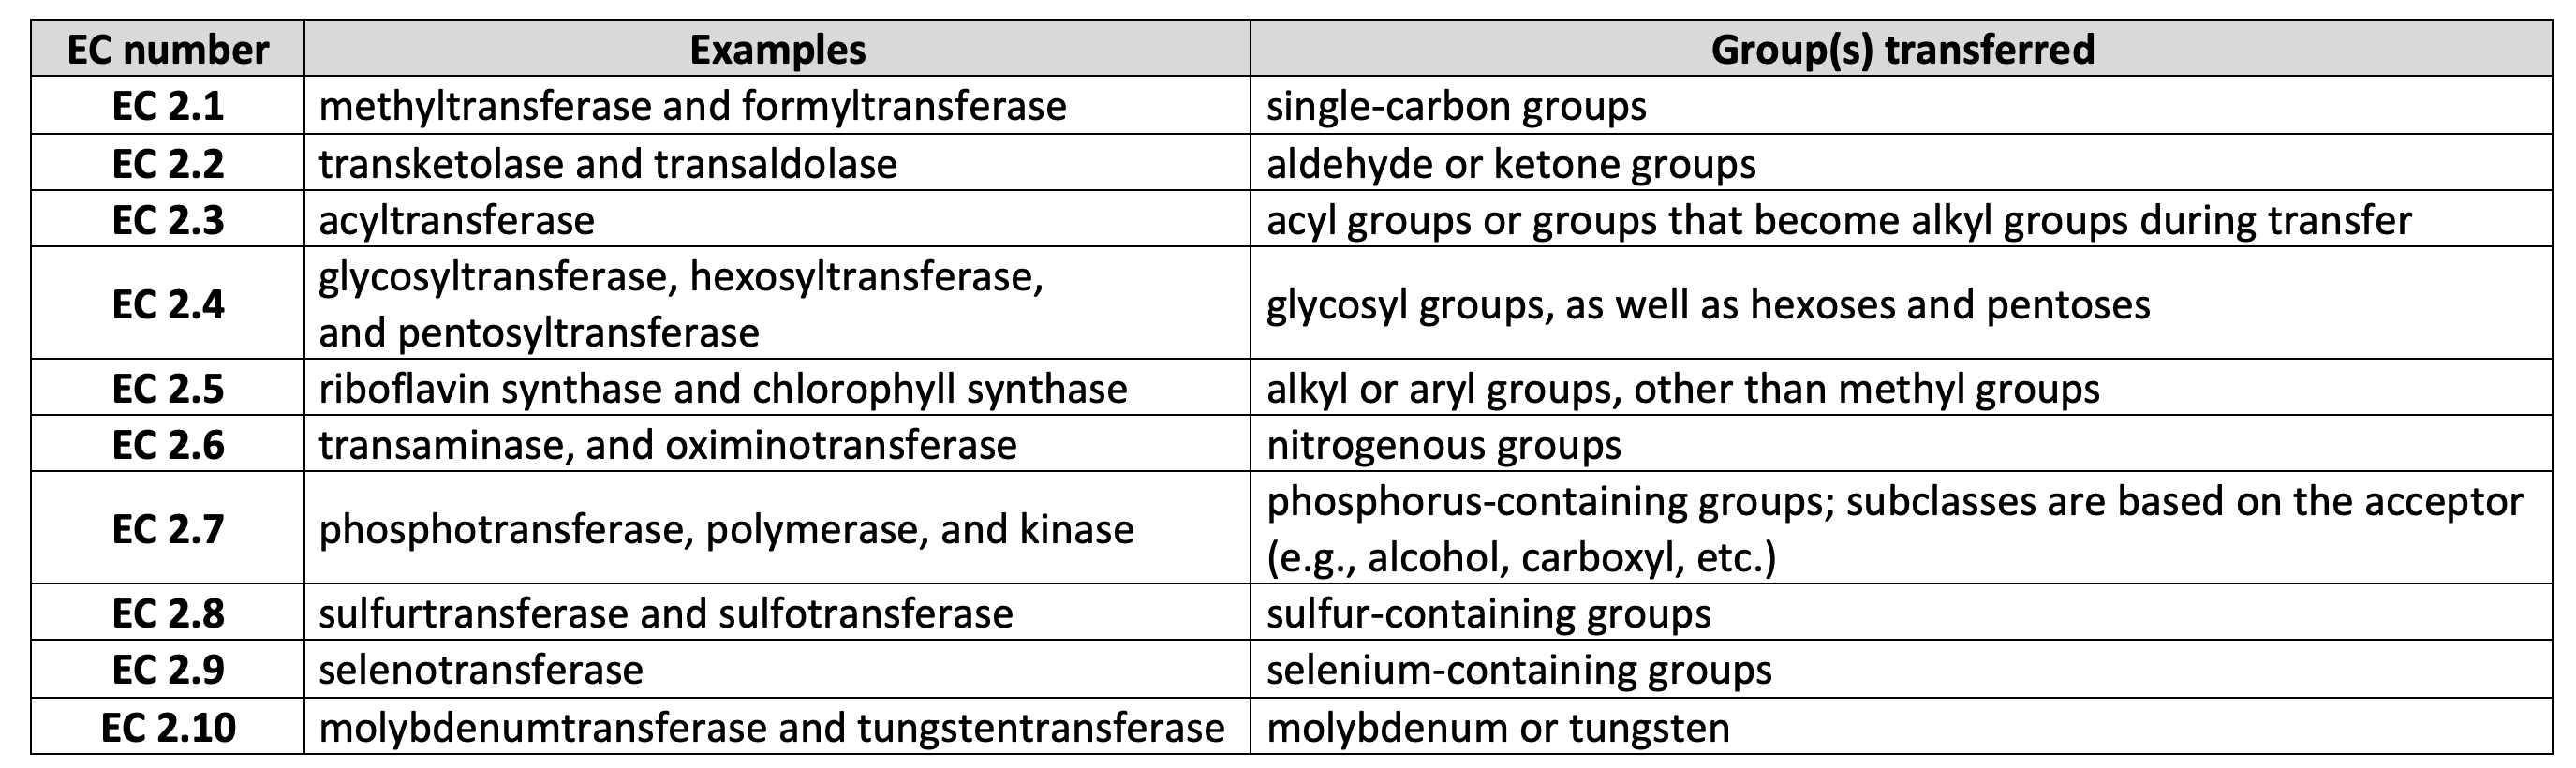

# Initial exploration and preprocessing

### Imports

In [1]:
from IPython.display import SVG
from  IPython.display import Image as displayImage
import io
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

random.seed(1) 
np.random.seed(1)

### Dataset upload

The first step, analyzing this dataset, includes loading and displaying the data.

In [2]:
data = pd.read_csv('ecpred_uniprot_uniref_90.csv')
data.head()

,uniref_90,Entry,Protein names,ec_number,sequence,pfam,supfam,go
0,Q65GK1,Q65GK1,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MRNIIVGSRRSKLAMTQTKWVIKKLEELNPDFTFEIKEIVTKGDRI...,PF01379;PF03900;,SSF54782;,GO:0004418; GO:0006782; GO:0018160
1,P16616,P16616,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MMRTIKVGSRRSKLAMTQTKWVIQKLKEINPSFAFEIKEIVTKGDR...,PF01379;PF03900;,SSF54782;,GO:0004418; GO:0005737; GO:0006782; GO:0006783...
2,Q1LU25,Q1LU25,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MLNNILKIATRQSPLAIWQANYVRNQLLSFYPTLLIELVPIVTSGD...,PF01379;PF03900;,SSF54782;,GO:0004418; GO:0006782; GO:0018160
3,Q7VRM4,Q7VRM4,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MQAKILRIATRKSPLAICQACYVCNKLKHYHPHIQTELIPIITTGD...,PF01379;PF03900;,SSF54782;,GO:0004418; GO:0006782
4,Q491Z6,Q491Z6,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MKNKILKIATRKSQLAICQAQYVHNELKHYHPTLSIELMPIVTTGD...,PF01379;PF03900;,SSF54782;,GO:0004418; GO:0006782


In [3]:
print('Features:',data.columns)

Features: Index(['uniref_90', 'Entry', 'Protein names', 'ec_number', 'sequence', 'pfam',
       'supfam', 'go'],
      dtype='object')


The dataset contains the following features:

- **uniref_90:** Identifier number. Composed of sequences that have at least 90% sequence identity to, and 80% overlap with, the longest sequence in the cluster 
- **Entry:** Entry name for UniProt
- **Protein names**
- **ec_number**
- **sequence**
- **pfam:** Family domains
- **supfam:** Superfamily domains
- **go:** Gene ontology 

We droped the nan values of sequence and pfam because they are not relevant to the following study.

The dataset was loaded under the name 'data'.

In [4]:
data = data.dropna(subset=['sequence', 'pfam'])

In [5]:
print('Dataset dimension:',data.shape)

Dataset dimension: (167636, 8)


The dataset is composed of 167636 sequences and 8 features.

### Dataset manipulation

To extract the ec levels, class and subclass, we have made the function get_ec_level. This function can extract the first value (class) of the ec_number and the second value (subclass).

In [6]:
from collections import Counter

def get_ec_level (data, level:int) -> list:
    '''
    Performs the extraction of ec_level 0 (class) and ec_level 1 (subclass).
    Returns a list with the ec_levels selected.
    
    Parameters
    ----------
    data: Dataset
        Dataset object
    level: int
        Level to extract
    '''
    l = []
    for ec_list in data['ec_number']:
        if level == 0:
            ec = [x.strip()[0] for x in ec_list.split(';')]
        else:
            ec = [x.split('.')[1] for x in ec_list.split(';')]
        l.append(list(set(ec))) # can contain more than one ec number
    return l

We started to select the classes and make a counter to know the number of samples.
Some rows can contain more than one ec_number/class so we selected only the rows that had one.
We added a new column to the dataset, ec_lev, with the corresponding classes.

In [7]:
data['ec_lev'] = get_ec_level(data,0)  #add a new column
data = data.loc[data['ec_lev'].apply(len)<2,:] # rows that only contain one EC_NUMBER
counts = Counter(x for xs in data['ec_lev'] for x in set(xs)) 
print(f'Number of sequences in each class:\n',counts.most_common()) 

Number of sequences in each class:
 [('2', 51541), ('3', 33249), ('0', 20559), ('1', 18412), ('6', 16064), ('4', 12698), ('5', 7900), ('7', 6723)]


To visualize more easily the number of samples for each class we ploted the results.

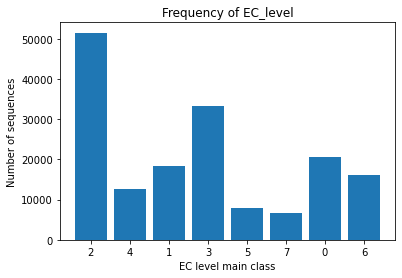

In [8]:
import matplotlib.pyplot as plt

plt.bar(*zip(*counts.items()))
plt.xlabel('EC level main class')
plt.ylabel('Number of sequences')
plt.title('Frequency of EC_level')
plt.show()

Analyzing the barplot we can easily see that class 2 has more samples.

To more easily work with the feature ec_lev we passed the rows from lists to strings.

In [9]:
data['ec_lev'] = [','.join(map(str, l)) for l in data['ec_lev']]
data.head()

,uniref_90,Entry,Protein names,ec_number,sequence,pfam,supfam,go,ec_lev
0,Q65GK1,Q65GK1,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MRNIIVGSRRSKLAMTQTKWVIKKLEELNPDFTFEIKEIVTKGDRI...,PF01379;PF03900;,SSF54782;,GO:0004418; GO:0006782; GO:0018160,2
1,P16616,P16616,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MMRTIKVGSRRSKLAMTQTKWVIQKLKEINPSFAFEIKEIVTKGDR...,PF01379;PF03900;,SSF54782;,GO:0004418; GO:0005737; GO:0006782; GO:0006783...,2
2,Q1LU25,Q1LU25,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MLNNILKIATRQSPLAIWQANYVRNQLLSFYPTLLIELVPIVTSGD...,PF01379;PF03900;,SSF54782;,GO:0004418; GO:0006782; GO:0018160,2
3,Q7VRM4,Q7VRM4,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MQAKILRIATRKSPLAICQACYVCNKLKHYHPHIQTELIPIITTGD...,PF01379;PF03900;,SSF54782;,GO:0004418; GO:0006782,2
4,Q491Z6,Q491Z6,Porphobilinogen deaminase (PBG) (EC 2.5.1.61) ...,2.5.1.61,MKNKILKIATRKSQLAICQAQYVHNELKHYHPTLSIELMPIVTTGD...,PF01379;PF03900;,SSF54782;,GO:0004418; GO:0006782,2


### Classes analysis and visualization

To obtain the more representative class and a more balanced data we performed analysis to all the enzymatic classes.

For this analysis:
- we started to select each class;
- after that, we selected the respective subclasses (we only returned the ones that only had one);
- we performed a counter of each subclass and ploted the results.

#### Class 1

In [10]:
data_1 = data.loc[data['ec_lev'] == '1',:]
data_1 = data_1.reset_index()
print('Class 1 shape:',data_1.shape)

Class 1 shape: (18412, 10)


In [11]:
data_1['ec_lev'] = get_ec_level(data_1,1) 
data_1 = data_1.loc[data_1['ec_lev'].apply(len)<2,:]

In [12]:
counts_1 = Counter(x for xs in data_1['ec_lev'] for x in set(xs))
counts_1.most_common() 

[('1', 4337),
 ('14', 2381),
 ('2', 1987),
 ('3', 1814),
 ('17', 1027),
 ('4', 926),
 ('8', 896),
 ('11', 854),
 ('7', 699),
 ('-', 621),
 ('13', 547),
 ('5', 355),
 ('18', 344),
 ('6', 330),
 ('15', 306),
 ('10', 258),
 ('16', 184),
 ('97', 171),
 ('12', 109),
 ('21', 84),
 ('9', 59),
 ('23', 16),
 ('20', 15)]

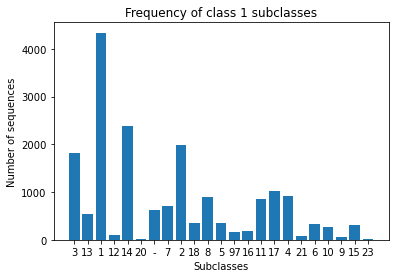

In [13]:
plt.bar(*zip(*counts_1.items()))
plt.xlabel('Subclasses')
plt.ylabel('Number of sequences')
plt.title('Frequency of class 1 subclasses')
plt.show()

The class 1 has a significant number of sequences but the subclasses are not well balanced.

#### Class 2

In [14]:
data_2 = data.loc[data['ec_lev'] == '2',:]
data_2 = data_2.reset_index()
print('Class 2 shape:',data_2.shape)

Class 2 shape: (51541, 10)


In [15]:
data_2['ec_lev'] = get_ec_level(data_2,1) 
data_2 = data_2.loc[data_2['ec_lev'].apply(len)<2,:]
data_2.shape

(51090, 10)

In [16]:
counts_2 = Counter(x for xs in data_2['ec_lev'] for x in set(xs))
counts_2.most_common() 

[('7', 18923),
 ('1', 9834),
 ('3', 7179),
 ('4', 5899),
 ('5', 4646),
 ('8', 2219),
 ('6', 1404),
 ('2', 838),
 ('-', 75),
 ('9', 63),
 ('10', 10)]

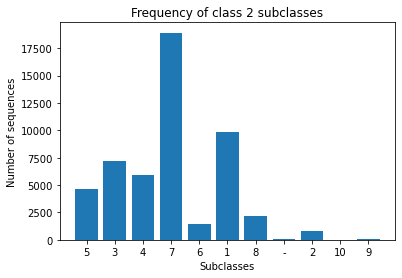

In [17]:
plt.bar(*zip(*counts_2.items()))
plt.xlabel('Subclasses')
plt.ylabel('Number of sequences')
plt.title('Frequency of class 2 subclasses')
plt.show()

The class 2 has a significant number of sequences and we can balance some of the subclasses by 2000 sequences.

#### Class 3

In [18]:
data_3 = data.loc[data['ec_lev'] == '3',:]
data_3 = data_3.reset_index()
print('Class 3 shape:',data_3.shape)

Class 3 shape: (33249, 10)


In [19]:
data_3['ec_lev'] = get_ec_level(data_3,1) 
data_3 = data_3.loc[data_3['ec_lev'].apply(len)<2,:]

In [20]:
counts_3 = Counter(x for xs in data_3['ec_lev'] for x in set(xs))
counts_3.most_common() 

[('1', 11154),
 ('4', 6994),
 ('6', 6818),
 ('5', 4285),
 ('2', 2942),
 ('-', 175),
 ('3', 155),
 ('7', 108),
 ('8', 35),
 ('11', 22),
 ('9', 7),
 ('13', 4),
 ('10', 1)]

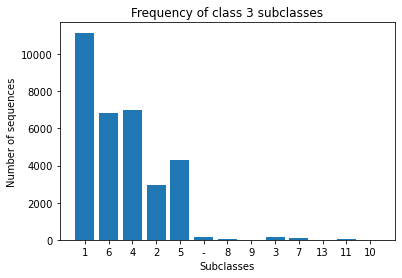

In [21]:
plt.bar(*zip(*counts_3.items()))
plt.xlabel('Subclasses')
plt.ylabel('Number of sequences')
plt.title('Frequency of class 3 subclasses')
plt.show()

The class 3 has a significant number of sequences but the subclasses are not well balanced like we can see for the last 8 that has barely any samples.

#### Class 4

In [22]:
data_4 = data.loc[data['ec_lev'] == '4',:]
data_4 = data_4.reset_index()
print('Class 4 shape:',data_4.shape)

Class 4 shape: (12698, 10)


In [23]:
data_4['ec_lev'] = get_ec_level(data_4,1) 
data_4 = data_4.loc[data_4['ec_lev'].apply(len)<2,:]

In [24]:
counts_4 = Counter(x for xs in data_4['ec_lev'] for x in set(xs))
counts_4.most_common()

[('2', 5637),
 ('1', 4153),
 ('3', 1554),
 ('6', 713),
 ('4', 268),
 ('99', 259),
 ('-', 86),
 ('5', 4),
 ('7', 2)]

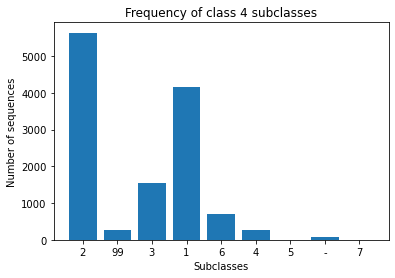

In [25]:
plt.bar(*zip(*counts_4.items()))
plt.xlabel('Subclasses')
plt.ylabel('Number of sequences')
plt.title('Frequency of class 4 subclasses')
plt.show()

The class 4 has a significant number of sequences but the subclasses are not well balanced.

#### Class 5

In [26]:
data_5 = data.loc[data['ec_lev'] == '5',:]
data_5 = data_5.reset_index()
print('Class 5 shape:',data_5.shape)

Class 5 shape: (7900, 10)


In [27]:
data_5['ec_lev'] = get_ec_level(data_5,1) 
data_5 = data_5.loc[data_5['ec_lev'].apply(len)<2,:]

In [28]:
counts_5 = Counter(x for xs in data_5['ec_lev'] for x in set(xs))
counts_5.most_common()

[('4', 2678),
 ('3', 2570),
 ('1', 1212),
 ('2', 944),
 ('6', 396),
 ('5', 86),
 ('-', 11),
 ('99', 3)]

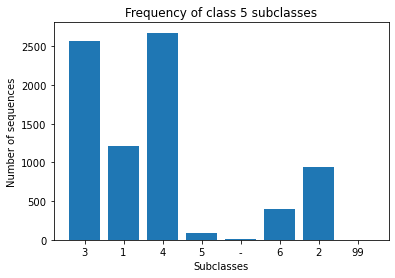

In [29]:
plt.bar(*zip(*counts_5.items()))
plt.xlabel('Subclasses')
plt.ylabel('Number of sequences')
plt.title('Frequency of class 5 subclasses')
plt.show()

The class 5 has a significant number of sequences but the subclasses are not well balanced like we can see for the subclass - and 99 that has barely any samples.

#### Class 6

In [30]:
data_6 = data.loc[data['ec_lev'] == '6',:]
data_6 = data_6.reset_index()
print('Class 6 shape:',data_6.shape)

Class 6 shape: (16064, 10)


In [31]:
data_6['ec_lev'] = get_ec_level(data_6,1) 
data_6 = data_6.loc[data_6['ec_lev'].apply(len)<2,:]

In [32]:
counts_6 = Counter(x for xs in data_6['ec_lev'] for x in set(xs))
counts_6.most_common()

[('1', 7327),
 ('3', 7064),
 ('5', 743),
 ('2', 734),
 ('-', 73),
 ('4', 59),
 ('6', 44)]

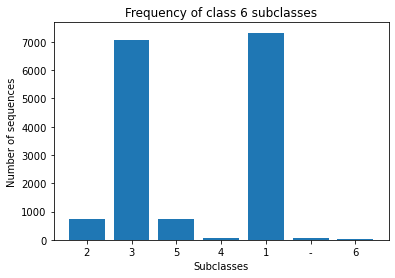

In [33]:
plt.bar(*zip(*counts_6.items()))
plt.xlabel('Subclasses')
plt.ylabel('Number of sequences')
plt.title('Frequency of class 6 subclasses')
plt.show()

The class 6 has a significant number of sequences but the subclasses are not well balanced because we pratically just have samples for the subclasses 1 and 3.

#### Class 7

In [34]:
data_7 = data.loc[data['ec_lev'] == '7',:]
data_7 = data_7.reset_index()
print('Class 7 shape:',data_7.shape)

Class 7 shape: (6723, 10)


In [35]:
data_7['ec_lev'] = get_ec_level(data_7,1) 
data_7 = data_7.loc[data_7['ec_lev'].apply(len)<2,:]

In [36]:
counts_7 = Counter(x for xs in data_7['ec_lev'] for x in set(xs))
counts_7.most_common()

[('1', 4453),
 ('6', 768),
 ('2', 468),
 ('3', 465),
 ('5', 248),
 ('4', 164),
 ('-', 156)]

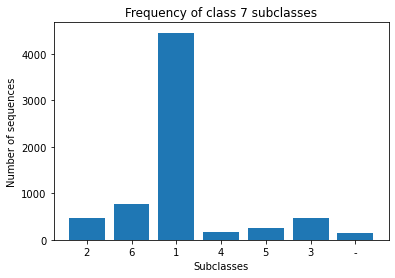

In [37]:
plt.bar(*zip(*counts_7.items()))
plt.xlabel('Subclasses')
plt.ylabel('Number of sequences')
plt.title('Frequency of class 7 subclasses')
plt.show()

The class 7 has a significant number of sequences but the subclasses are not well balanced because we pratically just have samples for the subclass 1.

**Conclusions of the classes analysis:**
- Comparying the plots for each class we concluded that the class 2 is the best candidate because we can more easily balance the data.

### Class 2 to dataset

Like we seen before, we selected the class 2 to study. Therefore, we had made a dataset containing only the data for this class.

Returning to the barplot of this class, we saw that the subclasses 2, 9, 10 and - had not enough samples compared to the remain so we decided to eliminate them so we can have a more balanced dataset. 

In [38]:
data_2['ec_lev'] = [','.join(map(str, l)) for l in data_2['ec_lev']]
data_2.head()
data_2.drop(data_2.loc[data_2['ec_lev'] == '10'].index, inplace=True)
data_2.drop(data_2.loc[data_2['ec_lev'] == '9'].index, inplace=True)
data_2.drop(data_2.loc[data_2['ec_lev'] == '-'].index, inplace=True)
data_2.drop(data_2.loc[data_2['ec_lev'] == '2'].index, inplace=True)

We selected 2000 random samples for each subclass and visualized the new dataset.

In [39]:
df_1 = data_2.loc[data_2['ec_lev'] == '1'].sample(n = 2000)
df_3 = data_2.loc[data_2['ec_lev'] == '3'].sample(n = 2000)
df_4 = data_2.loc[data_2['ec_lev'] == '4'].sample(n = 2000)
df_5 = data_2.loc[data_2['ec_lev'] == '5'].sample(n = 2000)
df_6 = data_2.loc[data_2['ec_lev'] == '6'] #has less than 2000 but is close so we will use it
df_7 = data_2.loc[data_2['ec_lev'] == '7'].sample(n = 2000)
df_8 = data_2.loc[data_2['ec_lev'] == '8'].sample(n = 2000)

data_new = pd.concat([df_1,df_3,df_4,df_5,df_6,df_7,df_8])
data_new = data_new.sample(frac = 1, random_state = 1).reset_index()
data_new.head()

,level_0,index,uniref_90,Entry,Protein names,ec_number,sequence,pfam,supfam,go,ec_lev
0,36250,109011,P0CN83,P0CN83,"1,4-alpha-glucan-branching enzyme (EC 2.4.1.18...",2.4.1.18,MTAVSLSDGTAVLKTDPWLEPFSGALRERYAAYQKQRTIIEEHEGG...,PF00128;PF02806;PF02922;,SSF51445;SSF81296;,GO:0003844; GO:0004553; GO:0005978; GO:0043169...,4
1,36790,110453,A5VXJ2,A5VXJ2,Thiosulfate sulfurtransferase GlpE (EC 2.8.1.1),2.8.1.1,MSEFKRIPPEQALELRKKEGAVVVDIRDPQAFAAGHITGARHLDNH...,PF00581;,SSF52821;,GO:0004792; GO:0005737; GO:0006071,8
2,31656,89041,A9HKH7,A9HKH7,Protoheme IX farnesyltransferase (EC 2.5.1.141...,2.5.1.141,MSGAATTEGAVTRFDAALVGTEARDWFALLKPRVISLVVFTGAAGL...,PF01040;,NaN,GO:0005886; GO:0008495; GO:0016021; GO:0048034,5
3,37795,112939,B4RV95,B4RV95,Serine hydroxymethyltransferase (SHMT) (Serine...,2.1.2.1,MFSREMNIADFDPELANAMANEVERQEHHIELIASENYCSPRVMEA...,PF00464;,SSF53383;,GO:0004372; GO:0005737; GO:0019264; GO:0030170...,1
4,4335,12074,Q55848,Q55848,Ribose-phosphate pyrophosphokinase (RPPK) (EC ...,2.7.6.1,MSAVSRIATLTRQSMLSALSDNNRLRLFSGSSNPSLSQEVARYLGM...,PF14572;PF13793;,SSF53271;,GO:0000287; GO:0002189; GO:0004749; GO:0005524...,7


In [40]:
print('Data new dimesion:',data_new.shape)

Data new dimesion: (13404, 11)


The new dataset has 13404 sequences and 11 features.

This dataset has aminoacids that are not common so we replaced them for usual ones.

In [41]:
new_seq = []
for seq in data_new['sequence']:  
    seq1 = seq.replace('B', 'N')  # asparagine N / aspartic acid  D - asx - B
    seq2 = seq1.replace('Z', 'Q')  # glutamine Q / glutamic acid  E - glx - Z
    seq3 = seq2.replace('U',
                        'C')  # selenocisteina, the closest is the cisteine. but it is a different aminoacid . take care.
    seq4 = seq3.replace('O', 'K')  # Pyrrolysine to lysine
    seq = seq4.replace('X', '')  # unknown character eliminated
    new_seq.append(seq)
data_new['sequence'] = new_seq

To later use of this dataset we converted it to a csv file.

In [42]:
data_new.to_csv('data_new.csv', index = False)

### Physicochemical descriptors

Calculus of several physicochemical properties of the protein sequence. Here we will use ProPythia package to calculate the descriptors.

Molecular descriptors are readily calculated from the chemical structure and provide an abundance of chemical and physical information about the compounds.

Physicochemical descriptors can take some time to run, so be aware of that when running this notebook.

In [43]:
from propythia.descriptors import Descriptor

def calculate_feature(data):
    list_feature = []
    count = 0
    total = data.shape[0]
    for seq in data['sequence']:
        count += 1
        res = {'sequence': seq}
        protein = Descriptor(seq)  # creating object to calculate descriptors
        # all physicochemical (16 descriptors: len, charge, chargedensity,bonds, molecularweight, formula, gravy, 
#         aromacity, isoelectricpoint, instability index, secstruct, instabilityindex, flexibility, boman index, 
#         molar extinction coefficient, hydrophobic ratio), AAC - 20, DPC - 21, PAAC - 24 , 32 CTD, 28 MoreauBroto

        feature = protein.adaptable([19, 20, 21, 24, 28, 32], lamda_paac = 4, lamda_apaac = 4)
        # lambda should not be larger than len(sequence)
        res.update(feature)
        list_feature.append(res)
        print(count, '/', total)
    df = pd.DataFrame(list_feature)
    df.insert(857,'ec_lev',data['ec_lev'])
    return df

data_feature = calculate_feature(data_new[:5])
data_feature

To later use of this dataset we converted it to a csv file.

In [44]:
# without functions for multiprocessing these descriptors can take a lot of time to be calculated. 
# So dont run this cell.

data_feature = calculate_feature(data_new)
data_feature.to_csv('ecpred_uni90_feature.csv', index = False)

# Dataset Exploration

To analyse the new dataset with the descriptors, we loaded and displayed the data.

In [2]:
data_feature = pd.read_csv('ecpred_uni90_feature.csv')
data_feature

,sequence,lenght,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,tot,...,_HydrophobicityD2025,_HydrophobicityD2050,_HydrophobicityD2075,_HydrophobicityD2100,_HydrophobicityD3001,_HydrophobicityD3025,_HydrophobicityD3050,_HydrophobicityD3075,_HydrophobicityD3100,ec_lev
0,MTAVSLSDGTAVLKTDPWLEPFSGALRERYAAYQKQRTIIEEHEGG...,682.0,-16.361,-0.000209,3524,5256,920,1031,34,12414,...,57.358,118.491,185.660,256.981,0.457,89.498,161.644,232.877,311.416,4
1,MSEFKRIPPEQALELRKKEGAVVVDIRDPQAFAAGHITGARHLDNH...,110.0,-5.666,-0.000476,520,788,144,170,2,1893,...,73.469,134.694,171.429,222.449,3.571,82.143,182.143,278.571,342.857,8
2,MSGAATTEGAVTRFDAALVGTEARDWFALLKPRVISLVVFTGAAGL...,315.0,6.057,0.000179,1563,2417,399,407,16,5575,...,50.360,114.388,166.187,223.022,0.787,65.354,129.134,185.039,247.244,5
3,MFSREMNIADFDPELANAMANEVERQEHHIELIASENYCSPRVMEA...,418.0,-11.995,-0.000266,1974,3062,530,631,17,7256,...,61.714,116.571,164.571,238.286,0.833,96.667,181.667,267.500,346.667,1
4,MSAVSRIATLTRQSMLSALSDNNRLRLFSGSSNPSLSQEVARYLGM...,333.0,-0.532,-0.000015,1582,2544,446,495,15,5902,...,64.341,125.581,195.349,255.814,0.917,74.312,156.881,228.440,304.587,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13399,MTEESHPLRGAGNFFGRRHGKPLRSHQKNLFEDLLPRLKINVENPA...,233.0,5.136,0.000190,1217,1826,358,338,4,4301,...,75.556,131.111,202.222,254.444,1.587,85.714,174.603,257.143,366.667,1
13400,MKSYTPYFILLWSAVGIAKAAKIIIVPPIMFESHMYIFKTLASALH...,541.0,23.206,0.000378,2823,4360,734,758,17,9998,...,59.314,130.392,193.137,262.745,0.515,69.072,128.866,203.608,278.351,4
13401,MLTIAQHQFESRLFTGTGKFAASEIMLTAIQASQSQLVTLAIKRLD...,255.0,-4.563,-0.000168,1190,1909,319,372,11,4438,...,65.421,136.449,191.589,233.645,1.205,69.880,144.578,212.048,303.614,8
13402,MDELLLQDPEVGKAIILEIERQTGKLELIASENFVSAAVRQAQGSV...,412.0,-2.889,-0.000065,1961,3075,537,601,13,7160,...,63.333,116.667,165.556,228.333,0.833,85.833,165.000,260.833,343.333,1


 ## Pre processing

We displayed the features names to see what they are.

Some examples of descriptors are:
- Physicochemical basic descriptors: length, charge, molecular weight, bonds (hydrogen, single, double bond), formula (number of C,H,N,O,S), chargedensity, gravy, aromacity, isoelectricpoint, instability index, secstruct, instabilityindex, flexibility, boman index, molar extinction coefficient, hydrophobic ratio. 
- Aminoacid composition: fractions of all 20 aa. 
- Dipeptide composition: fractions of all 400 possible combinations of 2 aa.
- Pseudo amino Acid composition: represents AAC but with additional information to represent some local features, such as correlation between residues of a certain distance. 
- Composition, Transition Distribution (CTD) descriptors: Overall Composition, Transition and Distribution (CTD) of amino acid attributes such as hydrophobicity, normalized van der Waals volume, polarity, polarizability, charge, secondary structure and solvent accessibility of the protein sequences.
- Autocorrelation descriptors: describe the level of correlation between two objects (protein or peptide sequences) in terms of their specific structural or physicochemical property defined based on the distribution of amino acid properties along the sequence. Eight amino acid properties are used for deriving the autocorrelation descriptors: hydrophobicity scale; average flexibility index; polarizability parameter; free energy of amino acid solution in water; residue accessible surface areas; amino acid residue volumes; steric parameters; and relative mutability.

### Exploring the descriptors

#### Checking the amino acid frequency

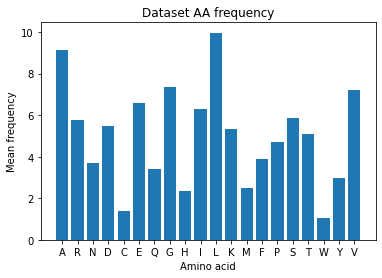

In [4]:
aa = data_feature.iloc[:,26:46].mean()
plt.bar(aa.index, aa.values)
plt.xlabel("Amino acid")
plt.ylabel("Mean frequency")
plt.title("Dataset AA frequency")
plt.show()

#### Check distribution of the hydrophobic ratio

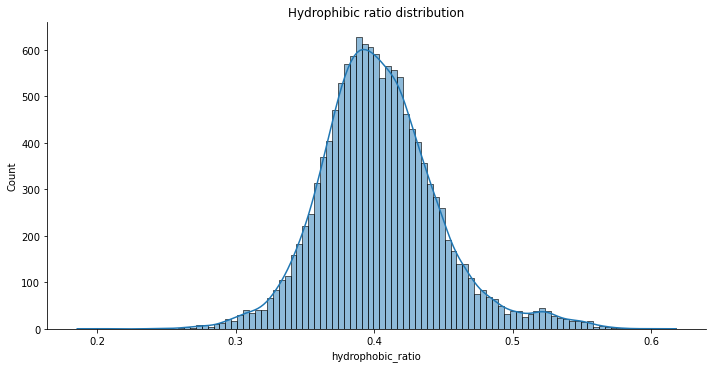

In [90]:
sns.displot(data_feature['hydrophobic_ratio'], aspect=2, height=5, kde=True).set(title="Hydrophibic ratio distribution")

#### Checking distribution of the charge

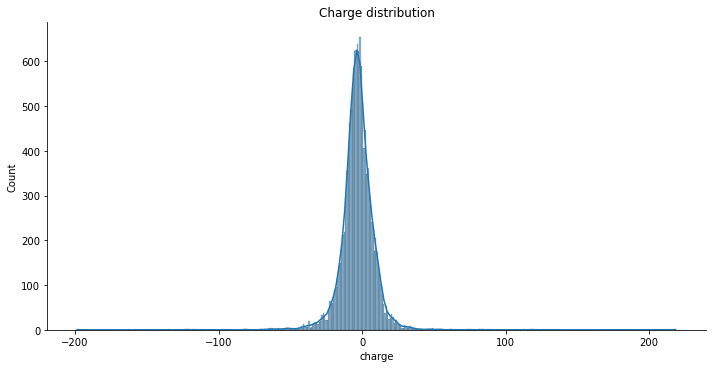

In [91]:
sns.displot(data_feature['charge'], aspect=2, height=5, kde=True).set(title="Charge distribution")

#### Checking distribution of the helix structure

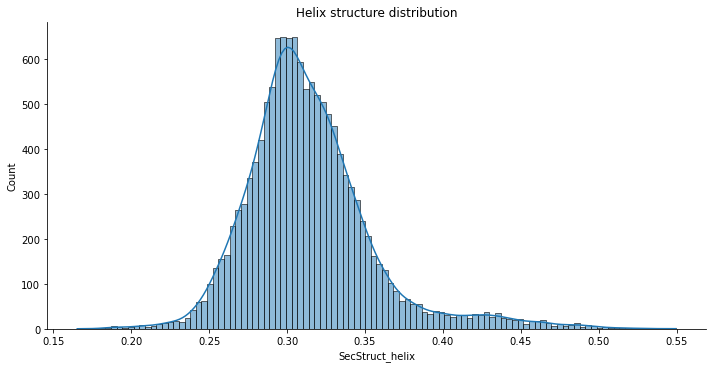

In [83]:
sns.displot(data_feature['SecStruct_helix'], aspect=2, height=5, kde=True).set(title="Helix structure distribution")

#### Checking distribution of the turn structure

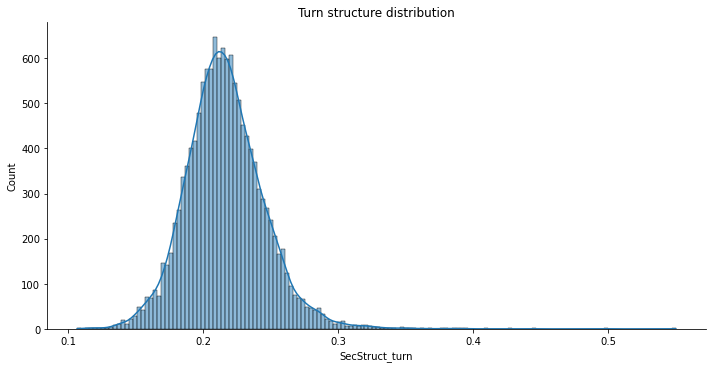

In [85]:
sns.displot(data_feature['SecStruct_turn'], aspect=2, height=5, kde=True).set(title="Turn structure distribution")

#### Checking distribution of the sheet structure

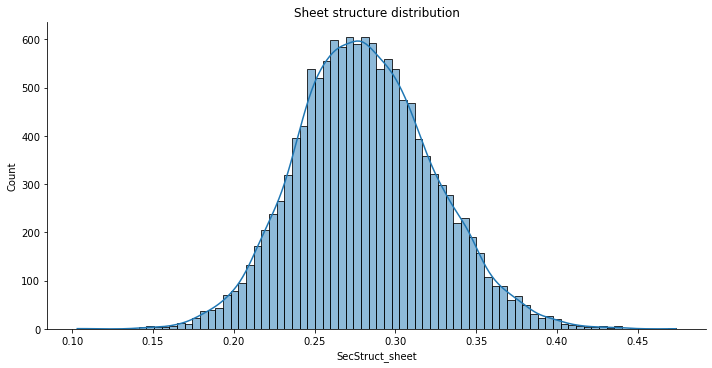

In [86]:
sns.displot(data_feature['SecStruct_sheet'], aspect=2, height=5, kde=True).set(title="Sheet structure distribution")

#### Checking distribution of the isoelectric point

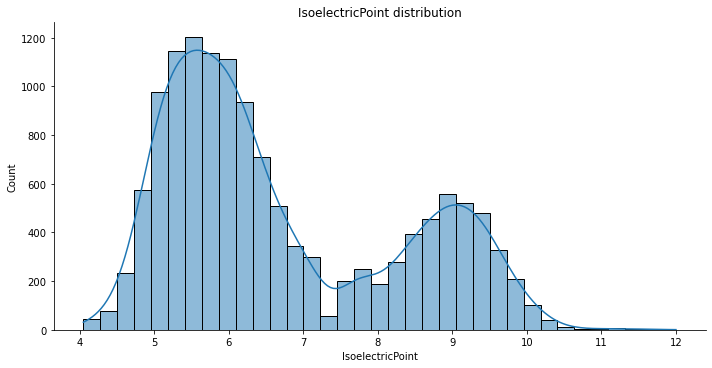

In [87]:
sns.displot(data_feature['IsoelectricPoint'], aspect=2, height=5, kde=True).set(title="IsoelectricPoint distribution")

#### Check distribution of the instability index

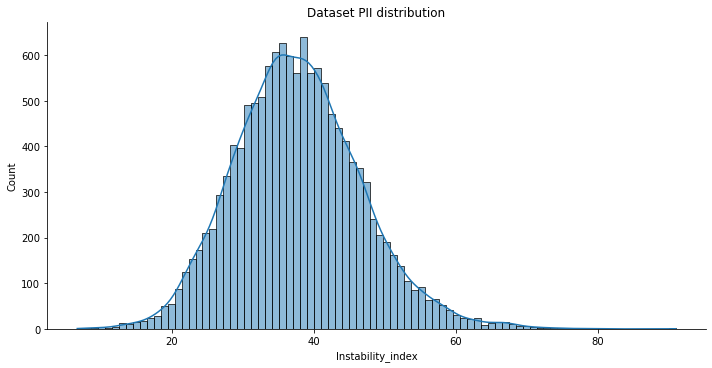

In [92]:
sns.displot(data_feature['Instability_index'], aspect=2, height=5, kde=True).set(title="Dataset PII distribution")

Text(0.5, 1.0, 'Distribution of protein PII')

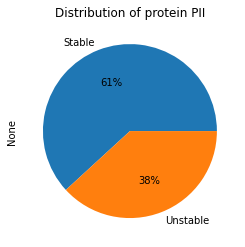

In [5]:
# check PII estimation of stability and instability
copy_df = data_feature.copy()

def stability(data):
    if data > 40: return 'Unstable'
    else: return 'Stable'

copy_df.groupby(data_feature['Instability_index'].apply(stability)).size().plot.pie(autopct='%d%%')
plt.title("Distribution of protein PII")

#### Dataset Features

In [23]:
list(data_feature.columns)

['sequence',
 'lenght',
 'charge',
 'chargedensity',
 'formulaC',
 'formulaH',
 'formulaN',
 'formulaO',
 'formulaS',
 'tot',
 'hydrogen',
 'single',
 'double',
 'MW_modlamp',
 'Gravy',
 'Aromacity',
 'IsoelectricPoint',
 'Instability_index',
 'SecStruct_helix',
 'SecStruct_turn',
 'SecStruct_sheet',
 'Molar_extinction_coefficient_reduced',
 'Molar_extinction_coefficient_oxidized',
 'aliphatic_index',
 'bomanindex',
 'hydrophobic_ratio',
 'A',
 'R',
 'N',
 'D',
 'C',
 'E',
 'Q',
 'G',
 'H',
 'I',
 'L',
 'K',
 'M',
 'F',
 'P',
 'S',
 'T',
 'W',
 'Y',
 'V',
 'AA',
 'AR',
 'AN',
 'AD',
 'AC',
 'AE',
 'AQ',
 'AG',
 'AH',
 'AI',
 'AL',
 'AK',
 'AM',
 'AF',
 'AP',
 'AS',
 'AT',
 'AW',
 'AY',
 'AV',
 'RA',
 'RR',
 'RN',
 'RD',
 'RC',
 'RE',
 'RQ',
 'RG',
 'RH',
 'RI',
 'RL',
 'RK',
 'RM',
 'RF',
 'RP',
 'RS',
 'RT',
 'RW',
 'RY',
 'RV',
 'NA',
 'NR',
 'NN',
 'ND',
 'NC',
 'NE',
 'NQ',
 'NG',
 'NH',
 'NI',
 'NL',
 'NK',
 'NM',
 'NF',
 'NP',
 'NS',
 'NT',
 'NW',
 'NY',
 'NV',
 'DA',
 'DR',
 'DN

In [3]:
print('Dataset dimension:',data_feature.shape)

Dataset dimension: (13404, 858)


The dataset with the descriptors now has 13404 sequences and 858 features.

We get the numeric representation of an array by identifying the distintive subclasses and grouped them to see the number of samples.

In [4]:
pd.factorize(data_feature['ec_lev'])
#encode the object as an enumerated type or categorical variable.

(array([0, 1, 2, ..., 1, 3, 1], dtype=int64),
 Int64Index([4, 8, 5, 1, 7, 6, 3], dtype='int64'))

In [5]:
print(data_feature.groupby('ec_lev').size())

ec_lev
1    2000
3    2000
4    2000
5    2000
6    1404
7    2000
8    2000
dtype: int64


We can see that the dataset is now well balanced.

We displayed basic metrics of the dataset.

In [27]:
data_feature.describe()

,lenght,charge,chargedensity,formulaC,formulaH,formulaN,formulaO,formulaS,tot,hydrogen,...,_HydrophobicityD2025,_HydrophobicityD2050,_HydrophobicityD2075,_HydrophobicityD2100,_HydrophobicityD3001,_HydrophobicityD3025,_HydrophobicityD3050,_HydrophobicityD3075,_HydrophobicityD3100,ec_lev
count,13404.000000,13404.000000,13404.000000,13404.000000,13404.000000,13404.000000,13404.000000,13404.000000,13404.000000,13404.000000,...,13404.000000,13404.000000,13404.000000,13404.000000,13404.000000,13404.000000,13404.000000,13404.000000,13404.000000,13404.000000
mean,395.752238,-3.183007,-0.000076,1942.929424,3057.417562,523.097956,592.257833,15.335795,7107.917189,3917.405551,...,67.098719,133.788780,200.139091,269.761020,0.985972,76.360687,154.112129,230.858296,310.643412,4.806326
std,263.384135,11.660122,0.000246,1295.481856,2023.553150,350.183294,409.369849,11.803654,4758.011875,2607.564532,...,13.566609,20.642458,27.244094,35.329674,0.605045,13.687875,20.228375,26.167408,32.611592,2.267318
min,35.000000,-198.502000,-0.001622,166.000000,261.000000,47.000000,53.000000,1.000000,604.000000,332.000000,...,28.512000,67.045000,109.836000,175.536000,0.061000,26.923000,80.992000,136.478000,178.616000,1.000000
25%,271.000000,-8.427750,-0.000219,1332.000000,2103.750000,355.750000,393.000000,9.000000,4869.000000,2685.000000,...,58.087000,119.403000,181.212000,244.737000,0.719000,68.468000,142.759250,216.374000,294.118000,3.000000
50%,350.000000,-3.132000,-0.000087,1703.000000,2688.000000,458.000000,517.000000,13.000000,6250.500000,3448.000000,...,65.187500,131.212000,196.875000,265.319500,0.893000,75.436000,153.782000,230.791500,310.894000,5.000000
75%,432.000000,2.451750,0.000067,2111.000000,3322.250000,569.000000,643.000000,19.000000,7711.250000,4257.250000,...,74.173000,145.255000,215.000000,289.308000,1.136000,83.333000,164.948000,245.556000,329.101750,7.000000
max,5233.000000,218.412000,0.001407,25026.000000,39545.000000,6817.000000,8079.000000,264.000000,93207.000000,51349.000000,...,193.846000,303.333000,442.500000,515.000000,39.130000,292.105000,370.175000,498.039000,574.837000,8.000000


Visualization of the NAN values.

In [28]:
print(f'Number of NAN values: {data_feature.isna().sum().sum()}')

Number of NAN values: 0


Visualization of the duplicated rows.

In [29]:
print(f'Number of duplicated rows: {data_feature.duplicated().sum()}')

Number of duplicated rows: 0


Visualization of the duplicated columns.

In [6]:
print(f'Number of duplicated columns: {data_feature.T.duplicated().sum()}')

Number of duplicated columns: 12


Removal of the duplicated columns.

In [7]:
data_feature = data_feature.T.drop_duplicates().T

print('New dimension:',data_feature.shape)

New dimension: (13404, 846)


To later use of this dataset we converted it to a csv file.

In [8]:
data_feature.to_csv('data_feature_new.csv', index = False)

To visualize the length of the sequences in the dataset we ploted them.

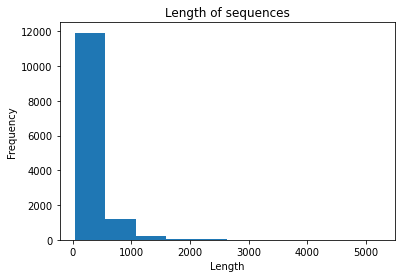

Maximum length:  5233.0
Minimum length:  35.0
Mean sequence length:  395.752


In [ ]:
plt.hist(data_feature.lenght)
plt.xlabel('Length')
plt.title('Length of sequences')
plt.ylabel('Frequency')
plt.show()
print('Maximum length: ', max(data_feature.lenght))
print('Minimum length: ', min(data_feature.lenght))
print('Mean sequence length: ', round(np.mean(data_feature.lenght), 3))

We can see that the majority of the sequences has less than 1000 aa.
The maximum length observed was 5233 and the minimum was 35.

To facilitate the further analysis we divided the dataset in two, x and y.
- The **data_feature_y** will only contain the feature ec_lev that as the subclasses. This will be used to make the predictions.
- In the **data_feature_x** we will drop the features sequence and ec_lev. 

In [9]:
data_feature_y = data_feature['ec_lev']
data_feature_x = data_feature.drop(['sequence','ec_lev'], axis=1)
print(f'y dimension: {data_feature_y.shape}')
print(f'X dimension: {data_feature_x.shape}')

y dimension: (13404,)
X dimension: (13404, 844)


To later use of this datasets we converted them to a csv file.

In [36]:
data_feature_y.to_csv('data_feature_y.csv', index = False)
data_feature_x.to_csv('data_feature_x.csv', index = False)